In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
import keras
import tensorflow as tf
import keras.backend as kb
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [14]:
def sampleMaker_entry(sample, input_size, output_size, entrada_var):
    n_slides = len(sample.index) - (output_size + input_size)+1
    entrada = np.array([np.array(sample[entrada_var].iloc[i:i+input_size]) for i in range(0, n_slides, input_size)])
    return entrada

def sampleMaker_out(sample, input_size, output_size, saida_var):
    n_slides = len(sample.index) - (output_size + input_size)+1
    saida = [sample[saida_var].iloc[i+input_size:i+input_size+output_size] for i in range(0, n_slides, input_size)]
    return saida

def splitter(data, group):
    data = list(data.groupby(group))
    data = [data[i][1] for i in range(len(data))]
    return data

base = pd.read_csv('/home/pa/Documents/github/doc_suomi/data/lstm/lstm.csv')
base = base.head(20)
base["track_number"] = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4] 

# LSTM model

## Data

Here I am doing my first attempt to use [Spotify's low-level descriptors](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-analysis). Rathar than having a single descriptor for each track, I'm working with several windows of audio description throughout each track.

- **Track lengths:** All tracks in the dataset have 5 non-overlapping time windows. In the original [API-call](https://github.com/pasoneto/doc_suomi/blob/main/code/api-call/web_api.py), data comes with different lengths of time frame (e.g. track 1 has 10 observations and track 2 has 5). In order to provide regular sized inputs to the LSTM architecture, I divided each track length in 5 quantile bins and calculated the mean for quantile within within each bin.

- **Feature engineering:** I also had the idea of calculating cummmulative track properties. The cumulative feature would work as a forced carrier of information from previous tracks. For Instance, if overall valence of track_1 is $10$, and overall valence of track_2 is $5$, the cummulative valence would be $15$. I did that for all variables in our data set. For the first track, cumulative value is simply the mean value of the feature within the track.

- **Data transformation:** Finally, all data was normalized with min-max transform, which I hear works better than z-scores for deep learning models by preserving the shapes of the distributions (?).

Below I'm showing two tracks of one album (5 rows for each).

In [15]:
base[["track_number", "valence", "energy", "loudness_continuous", "tempo_continuous", "valence_cat"]].head(20)


# le = preprocessing.LabelEncoder()
# base['valence_cat'] = le.fit_transform(base['valence_cat'])
# base['energy_cat'] = le.fit_transform(base['energy_cat'])
# base['loudness_cat'] = le.fit_transform(base['loudness_cat'])
# base['tempo_cat'] = le.fit_transform(base['tempo_cat'])

# base = splitter(base, "album_id")
# for i in base:
#     i.reset_index(drop = True, inplace = True)

,track_number,valence,energy,loudness_continuous,tempo_continuous,valence_cat
0,1,1.313627,1.774,1.659026,1.362158,start
1,1,1.313627,1.774,1.859440,1.352054,start
2,1,1.313627,1.774,1.813754,1.349711,start
3,1,1.313627,1.774,1.882299,1.558302,start
4,1,1.313627,1.774,1.608333,1.562684,start
5,2,1.213427,1.751,1.827929,1.546891,smaller
6,2,1.213427,1.751,1.930237,1.546697,smaller
7,2,1.213427,1.751,1.919182,1.548185,smaller
8,2,1.213427,1.751,1.884766,1.547523,smaller
9,2,1.213427,1.751,1.746617,1.546378,smaller


*Note: overal loudness is the grand average of the feature "loudness_continuous", which has 5 distinct values for each track. Here I'm asking if the overall loudness of track $i+1$ is higher or lower than the overall loudness of track $i$.

## Model architecture

The idea is to feed the LSTM with track $i$ and ask it to predict wether valence, energy, loudness, tempo go up or down in relation to the current feature value.

- **Features:** all descriptive features from [Spotify's web API](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-analysis) plus the cumulative features described before.

- **Input:** 5 time steps of each feature of track $i$.

- **Output:** Categorical transformation of valence, energy, loudness and tempo from track $i+1$ (i.e. "greater" or "lower")


### Input:

In [33]:
oi = base[1].head(10)
ent = oi.assign(track = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2], inplace = True)[['track', 'loudness_overall', 'loudness_continuous', 'loudness_overall_cum']]
said = pd.DataFrame({"track" : ["2"], "loudness_output" : ["Up"]}).reset_index(drop = True)
ent

,track,loudness_overall,loudness_continuous,loudness_overall_cum
0,1,1.90294,1.84793,1.01255
1,1,1.90294,1.88344,1.01255
2,1,1.90294,1.90009,1.01255
3,1,1.90294,1.87455,1.01255
4,1,1.90294,1.76004,1.01255
5,2,1.86245,1.72444,1.06252
6,2,1.86245,1.80856,1.06252
7,2,1.86245,1.73461,1.06252
8,2,1.86245,1.70248,1.06252
9,2,1.86245,1.84866,1.06252


### Output:

In [34]:
said

,track,loudness_output
0,2,Up


The output indicates that the overall loudness of track 2 went up in relation to loudness of track 1.

# Model evaluation

Data was trained on 80% of the dataset (without duplicate albums), and tested on the remaining 20%.
Accuracy ranges from 69% to 72%, against a baseline of 50%. 

The complete code that I wrote (in python) to train and test the model is [here](https://github.com/pasoneto/doc_suomi/blob/main/code/analysis/lstm_reboot.py).

In [35]:
treino = base[0:int(len(base)*0.8)]
teste = base[int(len(base)*0.8):len(base)]

In [36]:
albums_treino = [treino[i].album_id[0] for i in range(len(treino))]
albums_teste = [teste[i].album_id[0] for i in range(len(teste))]
albums_overall = [base[i].album_id[0] for i in range(len(base))]
(len(np.unique(np.array(albums_teste))) + len(np.unique(np.array(albums_treino)))) == len(np.unique(np.array(albums_overall)))


base[0].columns


Index(['Unnamed: 0', 'album_id', 'track_id', 'danceability_cum', 'energy_cum',
       'loudness_overall_cum', 'speechiness_cum', 'acousticness_cum',
       'instrumentalness_cum', 'liveness_cum', 'valence_cum',
       'tempo_overall_cum', 'duration_ms_cum', 'time_signature_cum',
       'loudness_continuous_cum', 'tempo_continuous_cum',
       'tempo_confidence_cum', 'key_confidence_cum', 'mode_confidence_cum',
       'time_signature_confidence_cum', 'danceability', 'energy',
       'loudness_overall', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo_overall', 'duration_ms', 'time_signature',
       'track_number', 'loudness_continuous', 'tempo_continuous',
       'tempo_confidence', 'key_confidence', 'mode_confidence',
       'time_signature_confidence', 'valence_cat', 'energy_cat',
       'loudness_cat', 'tempo_cat'],
      dtype='object')

In [37]:
entrada_var = ['danceability', 'energy', 'loudness_overall', 'mode_confidence','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_overall', 'duration_ms', 'time_signature_confidence', 'loudness_continuous', 'tempo_continuous', 'tempo_confidence', 'key_confidence', 'danceability_cum', 'energy_cum','loudness_overall_cum', 'speechiness_cum', 'acousticness_cum','instrumentalness_cum', 'liveness_cum', 'valence_cum','tempo_overall_cum', 'duration_ms_cum', 'time_signature_cum','loudness_continuous_cum', 'tempo_continuous_cum','tempo_confidence_cum', 'key_confidence_cum', 'mode_confidence_cum','time_signature_confidence_cum']
va  = ['valence_cat']
en  = ['energy_cat'] 
la  = ['loudness_cat'] 
te  = ['tempo_cat']

entrada_teste = list(map(lambda x : sampleMaker_entry(x, 5, 1, entrada_var), teste))
saida_valence   = list(map(lambda x : sampleMaker_out(x, 5, 1, va), teste))
saida_energy   = list(map(lambda x : sampleMaker_out(x, 5, 1, en), teste))
saida_loudness   = list(map(lambda x : sampleMaker_out(x, 5, 1, la), teste))
saida_tempo   = list(map(lambda x : sampleMaker_out(x, 5, 1, te), teste))

In [38]:
#import itertools
entrada_teste = np.array(list(itertools.chain.from_iterable(entrada_teste)))

saida_valence   = np.array(list(itertools.chain.from_iterable(saida_valence)))
saida_energy   = np.array(list(itertools.chain.from_iterable(saida_energy)))
saida_loudness   = np.array(list(itertools.chain.from_iterable(saida_loudness)))
saida_tempo   = np.array(list(itertools.chain.from_iterable(saida_tempo)))

In [39]:
# load json and create model
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix

valence = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/valence/model_valence.json', 'r')
valence = valence.read()
valence = model_from_json(valence)
valence.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/valence/model_valence.h5")

energy = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/energy/model_energy.json', 'r')
energy = energy.read()
energy = model_from_json(energy)
energy.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/energy/model_energy.h5")

loudness = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/loudness/model_loudness.json', 'r')
loudness = loudness.read()
loudness = model_from_json(loudness)
loudness.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/loudness/model_loudness.h5")

tempo = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/tempo/model_tempo.json', 'r')
tempo = tempo.read()
tempo = model_from_json(tempo)
tempo.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/tempo/model_tempo.h5")

In [40]:
# evaluate loaded model on test data
valence.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
energy.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
loudness.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
tempo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
pred_valence = list(itertools.chain.from_iterable(valence.predict_classes(entrada_teste)))
prob_valence = list(itertools.chain.from_iterable(valence.predict(entrada_teste)))
real_valence = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_valence))))

pred_energy = list(itertools.chain.from_iterable(energy.predict_classes(entrada_teste)))
prob_energy = list(itertools.chain.from_iterable(energy.predict(entrada_teste)))
real_energy = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_energy))))

pred_loudness = list(itertools.chain.from_iterable(loudness.predict_classes(entrada_teste)))
prob_loudness = list(itertools.chain.from_iterable(loudness.predict(entrada_teste)))
real_loudness = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_loudness))))

pred_tempo = list(itertools.chain.from_iterable(tempo.predict_classes(entrada_teste)))
prob_tempo = list(itertools.chain.from_iterable(tempo.predict(entrada_teste)))
real_tempo = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_tempo))))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Accuracy by feature

In [42]:
print(" Valence: ", accuracy_score(pred_valence, real_valence), "\n",
      "Energy: ", accuracy_score(pred_energy, real_energy),"\n",
      "Loudness: ", accuracy_score(pred_loudness, real_loudness),"\n",
      "Tempo: ", accuracy_score(pred_tempo, real_tempo))

 Valence:  0.7167381974248928 
 Energy:  0.689131191277114 
 Loudness:  0.5903027491010323 
 Tempo:  0.7259018675327689


## ROC curve and AUC for each feature

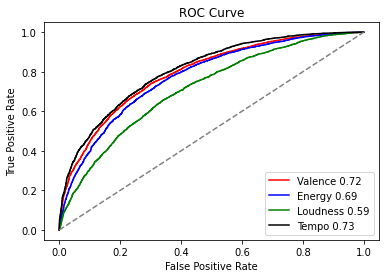

In [43]:
import matplotlib.pyplot as plt

vx, vy, vt = roc_curve(real_valence, prob_valence)
ex, ey, et = roc_curve(real_energy, prob_energy)
lx, ly, lt = roc_curve(real_loudness, prob_loudness)
tx, ty, tt = roc_curve(real_tempo, prob_tempo)


rasv = roc_auc_score(real_valence, pred_valence)
rase = roc_auc_score(real_energy, pred_energy)
rasl = roc_auc_score(real_loudness, pred_loudness)
rast = roc_auc_score(real_tempo, pred_tempo)

plt.plot(vx, vy, color = 'red',   label = f'Valence {round(rasv, 2)}')
plt.plot(ex, ey, color = 'blue',  label = f'Energy {round(rase, 2)}')
plt.plot(lx, ly, color = 'green', label = f'Loudness {round(rasl, 2)}')
plt.plot(tx, ty, color = 'black', label = f'Tempo {round(rast, 2)}')
plt.plot([0, 1], [0, 1], "r--", color = 'gray')
plt.title("ROC Curve")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


## Percentage of agreement

The metrics above relate to single feature. Below im evaluating the overall percentage of agreement (from real to predicted outputs) together with all variables.
I basically ran the percentage of agreement between two arrays: 1) the real categorical output for valence, energy, loudness and tempo, and 2) the predicted categorical output for the same variables.

Results are plotted below.

(array([  97.,    0.,  821.,    0.,    0., 2393.,    0., 3380.,    0.,
        1930.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

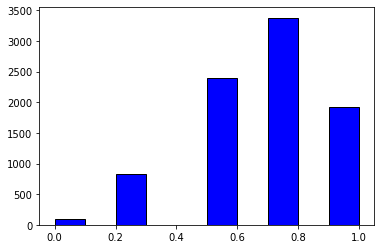

In [44]:
final = []
for i in range(len(saida_energy)):
    real = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable([saida_valence[i], saida_energy[i], saida_loudness[i], saida_tempo[i]]))))
    pred = [pred_valence[i], pred_energy[i], pred_loudness[i], pred_tempo[i]]
    final.append(accuracy_score(real, pred))
    
import seaborn as sns
plt.hist(final, color = 'blue', edgecolor = 'black')

Overall agreement: 0.6983466426723653
